In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg
import model as model

In [144]:
class PSO:
    def __init__(self, num_pop, num_dim, cognitive, social, bounds, min_velocity, max_velocity):
        '''
        num_pop: number of particles
        num_dim: dimesionality
        cognitive: cognitive component coeficient
        social: social component coeficient
        left_bound: left bound of particles search area
        right_bound right bound of particles search area
        min_velocity: minimal allowed velocity
        max_velocity: maximum allowed velocity
        '''
        assert 0 < cognitive < 4, "Cognitive coeficient must be in (0, 4)"
        assert 0 < social < 4, "Social coeficient must be in (0, 4)"
        assert np.all(max_velocity > 0), "Maximum velocity must be positive"

        self.num_pop = num_pop
        self.num_dim = num_dim

        self.cognitive = cognitive
        self.social = social

        self.left_bound, self.right_bound = bounds[:, 0], bounds[:, 1]

        self.min_velocity = min_velocity
        self.max_velocity = max_velocity

        # Initializing particles
        
        self.positions = np.random.rand(self.num_pop, self.num_dim) * (self.right_bound - self.left_bound) + self.left_bound
        
        self.best_positions = np.copy(self.positions) # initializing best positions as starting positions

        self.velocities = np.random.rand(self.num_pop, self.num_dim) * (self.max_velocity - self.min_velocity) + self.min_velocity

    def clip_position_higer(self, position):
        return np.where(position > self.right_bound, self.right_bound - abs(position - self.right_bound), position)
    
    def clip_positon_low(self, position):
        return np.where(position > self.left_bound, self.left_bound + abs(position - self.left_bound), position)
    
    def plot_regression(self, model, params, ax):
        left, right = min(model.X_train), max(model.X_train)
        r = np.linspace(left, right, 100)
        ax[0].scatter(model.X_train, model.y_train, label="Real data")
        ax[0].scatter(model.X_train, model.fit_function(model.X_train, params), label="Train")
        ax[0].plot(r, model.fit_function(r, params))
        ax[0].set_title("Training set")
        ax[0].legend()

        left, right = min(model.X_test), max(model.X_test)
        r = np.linspace(left, right, 100)
        ax[1].scatter(model.X_test, model.y_test, label="Real data")
        ax[1].scatter(model.X_test, model.fit_function(model.X_test, params), label="Test")
        ax[1].plot(r, model.fit_function(r, params))
        ax[1].set_title("Test set")
        ax[1].legend()
    
    def main_loop(self, model, num_iter=20, verbose=True, gif_name="PSO", regularizer=None, **kwargs):
        train_conv, test_conv = [], []

        # plotting
        n = num_iter // 5
        fig_convegence, ax_convergence = plt.subplots()
        fig_regression, ax_regression = plt.subplots(1, 2, figsize=(10, 5))
        images_convergence = []
        images_regression = []
        canvas_convergence = FigureCanvasAgg(fig_convegence)
        canvas_regression = FigureCanvasAgg(fig_regression)

        objective_function = model.loss
        best_fittnes = np.apply_along_axis(objective_function, axis=1,  arr=self.positions)

        leader = np.argmin(best_fittnes)

        # Initializing result variables
        global_minimum_position = self.positions[leader]
        global_minimum_value = np.min(best_fittnes)

        for i in range(1, num_iter + 1):
            # Random vectors
            r1 = np.random.rand(1, self.num_dim)
            r2 = np.random.rand(1, self.num_dim)

            # Modifying velocities
            self.velocities += (self.cognitive * (self.best_positions - self.positions) * r1 + 
                                    self.social * (global_minimum_position - self.positions) * r2)
            
            self.velocities = np.maximum(self.velocities, self.min_velocity)
            self.velocities = np.minimum(self.velocities, self.max_velocity)
            
            # Modifying positons
            self.positions += self.velocities

            # inverting velocities depending on particle position
            self.velocities = np.where((self.positions < self.left_bound) | (self.best_positions > self.right_bound), -self.velocities, self.velocities)

            # Clipping positions
            self.positions = self.clip_position_higer(self.positions)
            self.positions = self.clip_positon_low(self.positions)

            # Updating personal record
            fittnes = np.apply_along_axis(objective_function, axis=1,  arr=self.positions)

            # Updating postions
            for j in range(self.num_pop):
                if fittnes[j] < best_fittnes[j]:
                    self.best_positions[j] = self.positions[j]

            best_fittnes = np.minimum(best_fittnes, fittnes)
            
            leader = np.argmin(best_fittnes)

            # Upadating result
            if global_minimum_value > objective_function(self.positions[leader]) and not np.isinf(best_fittnes[leader]):
                global_minimum_position = np.copy(self.positions[leader])
                global_minimum_value = objective_function(self.positions[leader])

            train_loss = model.loss(global_minimum_position, regularizer=regularizer, **kwargs)
            test_loss = model.test_loss(global_minimum_position, regularizer=regularizer, **kwargs)
            train_conv.append(train_loss)
            test_conv.append(test_loss)

            if i % 10 == 0:
                ax_convergence.set_title(f"Particle Swarm Optimization on iteration {i}")

                ax_convergence.plot(test_conv[-n:], label="Test")
                ax_convergence.plot(train_conv[-n:], label="Train")
                ax_convergence.legend()
                # Render the plot as an RGBA buffer
                canvas_convergence.draw()
                buf = canvas_convergence.buffer_rgba()

                # Create a PIL Image from the RGBA buffer
                image = Image.frombytes('RGBA', canvas_convergence.get_width_height(), buf, 'raw', 'RGBA')
                images_convergence.append(image)
                ax_convergence.cla()

                # self.plot_regression(model, global_minimum_position, ax_regression)
                # canvas_regression.draw()
                # buf = canvas_regression.buffer_rgba()

                # image = Image.frombytes('RGBA', canvas_regression.get_width_height(), buf, 'raw', 'RGBA')
                # images_regression.append(image)
                # ax_regression[0].cla()
                # ax_regression[1].cla()

            if verbose:
                print("Ітерація %i\nЗначення %.3f\nТочка %s\n" % (i, global_minimum_value, global_minimum_position))

        # something like pause    
        images_convergence.extend([images_convergence[-1]] * max(100, num_iter // 25 + 1))

        images_convergence[0].save(f'{gif_name}_convergence.gif',
            save_all=True, append_images=images_convergence[1:], optimize=False, duration=10, loop=0)
        
        # # something like pause    
        # images_regression.extend([images_regression[-1]] * max(100, num_iter // 25 + 1))

        # images_regression[0].save(f'{gif_name}_regression.gif',
        #     save_all=True, append_images=images_regression[1:], optimize=False, duration=10, loop=0)
        
        plt.close()
        plt.title(f"Convergence")

        plt.plot(range(n, num_iter), test_conv[n:], label="Test")
        plt.plot(range(n, num_iter), train_conv[n:], label="Train")
        plt.legend()
        plt.show()


        return np.squeeze(global_minimum_position), (train_conv[-1], test_conv[-1])

In [152]:
class DE:
    def __init__(self, num_pop, num_dim, bounds):
        self.num_pop, self.num_dim = num_pop, num_dim
        self.left_bound, self.right_bound = bounds[:, 0], bounds[:, 1]
        self.population = np.random.rand(self.num_pop, self.num_dim) * (self.right_bound - self.left_bound) + self.left_bound

    def plot_regression(self, model, params, ax):
        left, right = min(model.X_train), max(model.X_train)
        r = np.linspace(left, right, 100)
        ax[0].scatter(model.X_train, model.y_train, label="Real data")
        ax[0].scatter(model.X_train, model.fit_function(model.X_train, params), label="Train")
        ax[0].plot(r, model.fit_function(r, params))
        ax[0].set_title("Training set")
        ax[0].legend()

        left, right = min(model.X_test), max(model.X_test)
        r = np.linspace(left, right, 100)
        ax[1].scatter(model.X_test, model.y_test, label="Real data")
        ax[1].scatter(model.X_test, model.fit_function(model.X_test, params), label="Test")
        ax[1].plot(r, model.fit_function(r, params))
        ax[1].set_title("Test set")
        ax[1].legend()

    def main_loop(self, num_iter, F, P, model, verbose=True, gif_name="DE", regularizer=None, **kwargs):
        best_res = np.inf
        best_pos = None

        train_conv, test_conv = [], []

        # plotting
        n = num_iter // 5
        fig_convergence, ax_convergence = plt.subplots()
        images_convergence = []
        canvas_convergence = FigureCanvasAgg(fig_convergence)


        for i in range(num_iter):
            for pos in range(self.num_pop):
                p1, p2, p3 = np.random.choice(self.num_pop, 3)

                while p1 == p2 or p2 == p3 or p1 == p3:
                    p1, p2, p3 = np.random.choice(self.num_pop, 3)

                x1, x2, x3 = self.population[[p1, p2, p3]]
                if F == "random":
                    F = np.random.rand() * 2
                v = x1 + F * (x2 - x3)

                v = np.where(np.random.rand(self.num_dim, ) < P, self.population[pos], v)

                if model.loss(v, regularizer, **kwargs) < model.loss(self.population[pos], regularizer, **kwargs):
                    self.population[pos] = v.copy()

            fitness = np.apply_along_axis(model.loss, 1, self.population)
            min_ind = fitness.argmin()

            if fitness[min_ind] < best_res:
                best_res = fitness[min_ind].copy()
                best_pos = self.population[min_ind].copy()

            train_loss, test_loss = model.loss(best_pos, regularizer, **kwargs), model.test_loss(best_pos, regularizer, **kwargs)
            train_conv.append(train_loss)
            test_conv.append(test_loss)

            if i % 10 == 0:
                ax_convergence.set_title(f"Differential Evolution Algorithm on iteration {i}")

                ax_convergence.plot(test_conv[-n:], label="Test")
                ax_convergence.plot(train_conv[-n:], label="Train")
                ax_convergence.legend()
                # Render the plot as an RGBA buffer
                canvas_convergence.draw()
                buf = canvas_convergence.buffer_rgba()

                # Create a PIL Image from the RGBA buffer
                image = Image.frombytes('RGBA', canvas_convergence.get_width_height(), buf, 'raw', 'RGBA')
                images_convergence.append(image)
                ax_convergence.cla()

            if verbose:
                print("Ітерація %i\nЗначення %.3f\nТочка %s\n" % (i + 1, best_res, best_pos))

        # something like pause    
        images_convergence.extend([images_convergence[-1]] * max(100, num_iter // 25 + 1))

        images_convergence[0].save(f'{gif_name}_convergence.gif',
            save_all=True, append_images=images_convergence[1:], optimize=False, duration=10, loop=0)
        
        plt.close()
        
        plt.title(f"Convergence")

        plt.plot(range(n, num_iter), test_conv[n:], label="Test")
        plt.plot(range(n, num_iter), train_conv[n:], label="Train")
        plt.legend()
        plt.show()

        return best_pos, (train_conv[-1], test_conv[-1])

In [ ]:
class Model:
    def __init__(self, X, y, regression_function, *, train_split=0.75):
        '''
        Intialize Model class

        X: 1-D array. Features array
        y: 1-D array. Labels array
        train_split: float in (0, 1) 
        regression_funcion: function to be fitted.

        '''
        self.regularizers = {
            'L2': lambda params, **kwargs: kwargs["l2"] * np.sum(params ** 2),
            'L1': lambda params, **kwargs: kwargs["l1"] * np.sum(np.abs(params)),
            'elastic_net': lambda params, **kwargs: kwargs["l1"] * np.sum(np.abs(params)) + kwargs['l2'] * np.sum(params ** 2)
        }
        self.train_test_partition(X, y, train_split)

        self.fit_function = regression_function

    def train_test_partition(self, X, y, train_split):
        '''
        Splitting data into test and train sets
        '''
        indices = np.random.permutation(len(X))
        n = int(len(X) * train_split)

        X, y = X[indices], y[indices]
        self.X_train, self.y_train = X[:n], y[:n]
        self.X_test, self.y_test = X[n:], y[n:]


    def loss(self, params, regularizer=None, **kwargs):
        '''
        Computes loss function
        '''
        y_hat = self.fit_function(x=self.X_train, params=params)
        mse = np.mean((y_hat - self.y_train) ** 2) / 2
        return mse + self.regularizers.get(regularizer, lambda params, **kwargs: 0)(params, **kwargs)
    
    def test_loss(self, params, regularizer=None, **kwargs):
        '''
        Computes loss function on test set
        '''
        y_hat = self.fit_function(x=self.X_test, params=params)
        mse = np.mean((y_hat - self.y_test) ** 2) / 2
        return mse + self.regularizers.get(regularizer, lambda params, **kwargs: 0)(params, **kwargs)

In [ ]:
def load_data(var=1):
    data = pd.read_excel("TestRegData.xlsx", sheet_name=f"Var{var}").to_numpy()
    return data[:, :-1], data[:, -1]

In [ ]:
def linear_function(x, params):
    """
    x: 2-D array
    params: 1-D array with params[0] = bias and params[1:] = weights
    """
    params.reshape(-1, 1)
    return np.dot(x, params[1:]) + params[0]

In [ ]:
X, y = load_data(1)

In [ ]:
test_model = Model(X, y, linear_function)

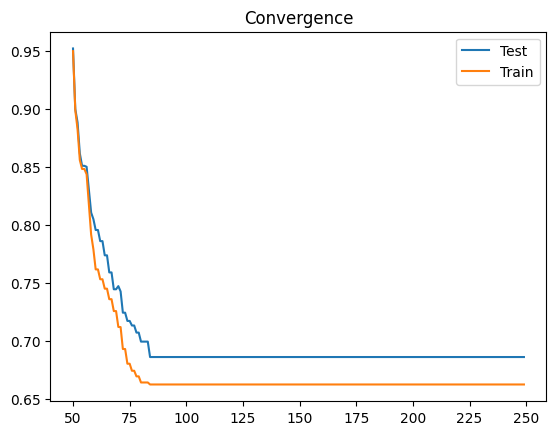

(array([ 2.98694953,  2.99933914,  2.52975265,  0.46636697,  2.95772421,
        -3.11873673, -2.22678507, -3.51880137, -3.13228996]),
 (0.6625055042215515, 0.6861769472453588))

In [145]:
pso_none = PSO(250, X.shape[1] + 1, 1, 3, np.array([[-3, 3]]), -0.1, 0.1)
pso_none.main_loop(test_model, 250, verbose=False, gif_name="PSO_none")

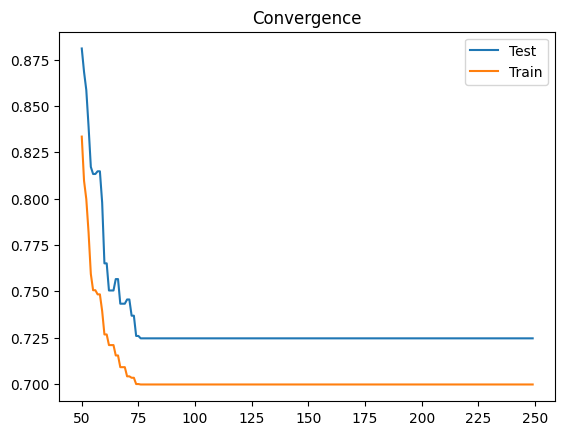

(array([ 2.9987033 ,  2.9621685 ,  2.49186515,  0.38182387,  2.99609467,
        -3.11678369, -2.44382639, -3.18452673, -3.14424077]),
 (0.6997719156495432, 0.7246521032302602))

In [146]:
pso_l1 = PSO(250, X.shape[1] + 1, 1, 3, np.array([[-3, 3]]), -0.1, 0.1)
pso_l1.main_loop(test_model, 250, verbose=False, gif_name="PSO_l1", regularizer="L1", l1=1e-4)

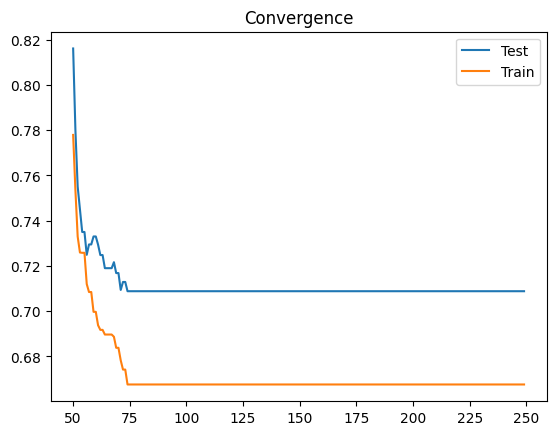

(array([ 2.96715381,  2.99079962,  2.74006575,  0.52257444,  2.99039942,
        -3.22654261, -2.37045526, -3.40162989, -3.17685757]),
 (0.667583875068342, 0.708806441724006))

In [147]:
pso_l1 = PSO(250, X.shape[1] + 1, 1, 3, np.array([[-3, 3]]), -0.1, 0.1)
pso_l1.main_loop(test_model, 250, verbose=False, gif_name="PSO_l2", regularizer="L2", l2=1e-4)

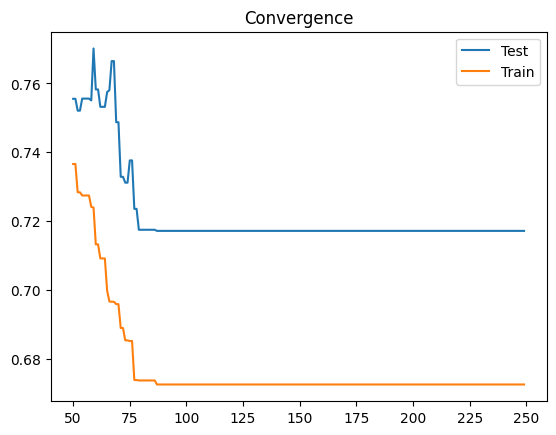

(array([ 2.99253543,  2.99865538,  2.65943811,  0.47211289,  2.95908596,
        -3.0104742 , -2.32958213, -3.33944829, -3.34364438]),
 (0.6726711561760681, 0.7172141009102557))

In [148]:
pso_l1 = PSO(250, X.shape[1] + 1, 1, 3, np.array([[-6, 6]]), -0.1, 0.1)
pso_l1.main_loop(test_model, 250, verbose=False, gif_name="PSO_elastic", regularizer="elastic_net", l1=1e-4, l2=1e-4)

Ітерація 1
Значення 3.683
Точка [ 1.95681906  2.35888447 -1.92977157  2.06637455  1.73046159 -2.62486917
 -1.60925008  0.48549599 -1.87337333]

Ітерація 2
Значення 2.502
Точка [ 2.58636114  2.30063765  1.8415291   0.21961285  0.35719977 -1.90535096
 -2.27666013 -2.12523694 -1.1612949 ]

Ітерація 3
Значення 2.502
Точка [ 2.58636114  2.30063765  1.8415291   0.21961285  0.35719977 -1.90535096
 -2.27666013 -2.12523694 -1.1612949 ]

Ітерація 4
Значення 2.502
Точка [ 2.58636114  2.30063765  1.8415291   0.21961285  0.35719977 -1.90535096
 -2.27666013 -2.12523694 -1.1612949 ]

Ітерація 5
Значення 2.502
Точка [ 2.58636114  2.30063765  1.8415291   0.21961285  0.35719977 -1.90535096
 -2.27666013 -2.12523694 -1.1612949 ]

Ітерація 6
Значення 1.664
Точка [ 2.31658209  2.70855373  1.52561596  1.19104243  2.12214512 -2.45554011
 -3.12484168 -2.84191379 -2.43970244]

Ітерація 7
Значення 1.664
Точка [ 2.31658209  2.70855373  1.52561596  1.19104243  2.12214512 -2.45554011
 -3.12484168 -2.84191379 -2.439

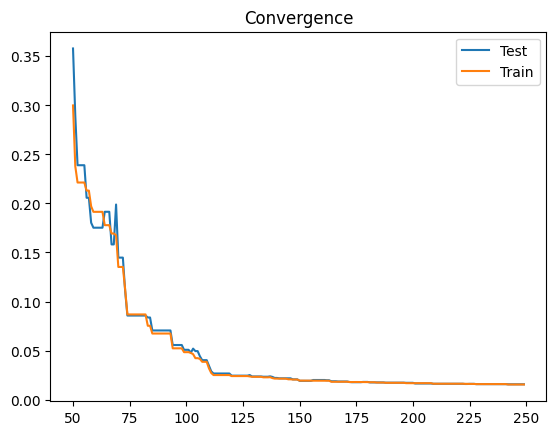

(array([ 3.89367899,  4.99900929,  2.04057115,  0.06740734,  5.01217768,
        -3.95578085, -2.97936635, -4.93929398, -4.95870407]),
 (0.015407951358512351, 0.015587573967843304))

In [153]:
de_test= DE(300, X.shape[1] + 1, np.array([[-3, 3]]))
de_test.main_loop(250, "random", 0.7, test_model, verbose=True, gif_name="DE_test", regularizer="L2", l2=1e-4)

Ітерація 1
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.59946959]

Ітерація 2
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.59946959]

Ітерація 3
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.59946959]

Ітерація 4
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.59946959]

Ітерація 5
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.59946959]

Ітерація 6
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.59946959]

Ітерація 7
Значення 1.757
Точка [-2.40364247  5.27993512  1.70501975  3.69408781  6.16965677  0.12097861
 -3.26692894 -3.87164061 -2.599

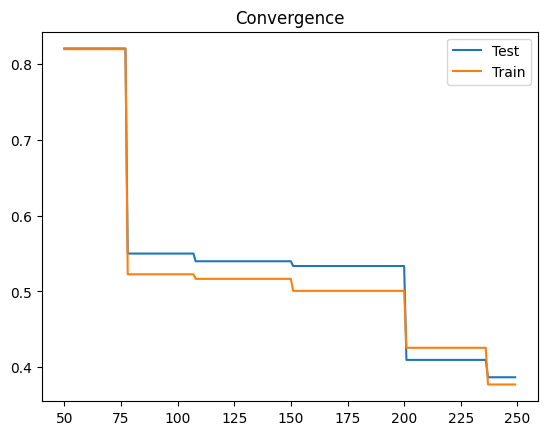

(array([ 4.22437019,  5.51350824,  1.12417057,  1.77786673,  5.57796444,
        -4.09980494, -2.6246029 , -5.67569441, -7.04079308]),
 (0.37729880409515976, 0.38681326067666194))

In [154]:
de_test= DE(300, X.shape[1] + 1, np.array([[-3, 3]]))
de_test.main_loop(250, "random", 0.7, test_model, verbose=True, gif_name="DE_none")